In [1]:
import pandas as pd
import numpy as np
from itertools import product

import seaborn as sns

traincsv = '../data/train.csv'
df = pd.read_csv(traincsv, index_col='Id')

In [2]:
df.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [3]:
df.columns = df.columns.map(lambda col: col.replace(' ','_').lower())
df.index.name = 'id'

Let's drop the PID.

In [4]:
df.drop('pid', axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 109 to 10
Data columns (total 79 columns):
ms_subclass        2051 non-null int64
ms_zoning          2051 non-null object
lot_frontage       1721 non-null float64
lot_area           2051 non-null int64
street             2051 non-null object
alley              140 non-null object
lot_shape          2051 non-null object
land_contour       2051 non-null object
utilities          2051 non-null object
lot_config         2051 non-null object
land_slope         2051 non-null object
neighborhood       2051 non-null object
condition_1        2051 non-null object
condition_2        2051 non-null object
bldg_type          2051 non-null object
house_style        2051 non-null object
overall_qual       2051 non-null int64
overall_cond       2051 non-null int64
year_built         2051 non-null int64
year_remod/add     2051 non-null int64
roof_style         2051 non-null object
roof_matl          2051 non-null object
exterior_1st       

The `ms_subclass` column should be an object, the numbers are just weird codes for various styles of home. This is not a persistent change in the sense that it won't change what happens when the saved CSV is read by pandas, ie I'll have to do this change again when reading the file back into a dataframe, but I'll do it here so I remember to in the future.

In [6]:
df['ms_subclass'] = df['ms_subclass'].astype('object').map(str)

Some columns encode the same information. For example there are a number of columns encoding information about the garage. Accoding to the documentation these columns are supposed to be be empty when there is no garage present. So if all of these columns are empty, we'll fill them with a string declaring that that indicates that the garage is missing. 

However if some of these columns have values but some do not, for example `Garage Finish` has a value but `Garage Cond` does not, we will drop that row. Some missing entries and some present indicates an error in the row. I'm going to ignore `Garage Yr Blt` for now and handle it at the end since I'm not sure what value it should actually take.

Fix the `pool_qc`, `misc_feature`, `alley`, `fence`, `fireplace_qe`

In [7]:
df['pool_qc'].fillna(value='No Pool', inplace=True)
df['misc_feature'].fillna(value='No Misc Feature', inplace=True)
df['alley'].fillna(value='No Alley', inplace=True)
df['fence'].fillna(value='No Fence', inplace=True)
df['fireplace_qu'].fillna(value='No Fireplace', inplace=True)

In [8]:
df.isnull().sum().sort_values(ascending=False).head()

lot_frontage     330
garage_yr_blt    114
garage_finish    114
garage_qual      114
garage_cond      114
dtype: int64

In [9]:
#keeps rows with no missing info, keeps rows which are missing every entry in the specified columns
#drops all the other rows, fills the missing entries with the new_value

def frame_column_filler(df, columns, new_value, inplace=False):
    if not inplace:
        tmp_df = df.copy()
    else:
        tmp_df = df
    
    num_nan = tmp_df[columns].isnull().sum(1)
    
    all_nan = set(num_nan[num_nan.apply(lambda x: x == len(columns))].index)
    no_nan = set(num_nan[num_nan.apply(lambda x: x == 0)].index)
    some_missing = {x for x in tmp_df.index if x not in all_nan.union(no_nan)}
    
    
    for index in tmp_df.index:
        if index in all_nan:
            for col in columns:
                tmp_df.at[index, col] = new_value
        elif index in some_missing:
            tmp_df.drop(index, inplace=True)
        
    if not inplace:
        return tmp_df

In [10]:
garage_cols = ['garage_cond', 'garage_qual', 'garage_finish', 'garage_type']
frame_column_filler(df, garage_cols, 'No Garage', inplace=True)

In [11]:
df.isnull().sum().sort_values(ascending=False).head()

lot_frontage      330
garage_yr_blt     113
bsmt_exposure      58
bsmtfin_type_2     56
bsmtfin_type_1     55
dtype: int64

I'm going to drop the `Garage Yr Blt` now and see how well we can do without it. I would think that newer garages would maybe be menaingful, but I'm not sure how to encode this column for those houses without a garage.

In [12]:
df.drop('garage_yr_blt', axis=1, inplace=True)

In [13]:
basement_cols = ['bsmt_exposure', 'bsmtfin_type_2', 'bsmt_cond', 'bsmt_qual','bsmtfin_type_1']
frame_column_filler(df, basement_cols, 'No Basement', inplace=True)

In [14]:
df.isnull().sum().sort_values(ascending=False).head()

lot_frontage      330
mas_vnr_type       22
mas_vnr_area       22
bsmt_full_bath      2
bsmt_half_bath      2
dtype: int64

In [15]:
masonry_cols = ['mas_vnr_area', 'mas_vnr_type']
df[df['mas_vnr_type'].isnull()]['mas_vnr_area']
df[(df['mas_vnr_type'].isnull())][masonry_cols]

,mas_vnr_area,mas_vnr_type
id,,
2393,NaN,NaN
2383,NaN,NaN
539,NaN,NaN
518,NaN,NaN
2824,NaN,NaN
1800,NaN,NaN
1455,NaN,NaN
1120,NaN,NaN
1841,NaN,NaN


In [16]:
df[df['mas_vnr_type'] == 'None'][masonry_cols].sort_values(by='mas_vnr_area', ascending=False).head(6)

,mas_vnr_area,mas_vnr_type
id,,
364,344.0,None
2529,288.0,None
1862,1.0,None
1914,1.0,None
2004,1.0,None
153,0.0,None


I think this is an error, so I'll drop those 5 at the top. I'll also drop the ones where one of the masonry entries is `NaN` since I'm not sure what thsoe ought to be otherwise, then we'll also drop the rows with missing masonry info.

In [17]:
df.drop([364, 2529, 1862, 1914, 2004], inplace=True)

In [18]:
df = df[~df['mas_vnr_type'].isnull() ]

In [19]:
df.isnull().sum().sort_values(ascending=False).head(10)

lot_frontage      322
bsmt_full_bath      2
bsmt_half_bath      2
bsmtfin_sf_1        1
bsmt_unf_sf         1
bsmtfin_sf_2        1
total_bsmt_sf       1
bsmtfin_type_2      0
bsmtfin_type_1      0
bsmt_exposure       0
dtype: int64

The final rows that I believe are true errors in the missing values are the ones below `Lot Frontage`. We'll drop those rows now, then impute values for `Lot Frontage` based on `MS SubClass`.

In [20]:
mask = df[[col for col in df.columns if col != 'lot_frontage']].isnull().sum(1).astype(bool)

In [21]:
df = df[~mask]

In [22]:
df.isnull().sum().sort_values(ascending=False).head(5)

lot_frontage    322
saleprice         0
foundation        0
roof_matl         0
exterior_1st      0
dtype: int64

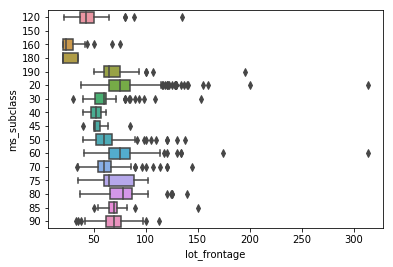

In [23]:
sns.boxplot(x='lot_frontage', y='ms_subclass', data=df, orient='h')

The values for `Lot Frontage` is very skewed even when grouped by `MS SubClass`, we'll replace all the missing values with the medians from that group.

In [24]:
df[['lot_frontage', 'ms_subclass']].groupby('ms_subclass').agg(np.median)

,lot_frontage
ms_subclass,
120,43.0
150,NaN
160,24.0
180,21.0
190,65.0
20,75.0
30,60.0
40,52.5
45,51.0


There's a missing median! 

In [25]:
df[df['ms_subclass'] == '150']

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
id,,,,,,,,,,,,,,,,,,,,,
2731,150,RL,NaN,1700,Pave,No Alley,Reg,HLS,AllPub,Inside,...,200,0,No Pool,No Fence,No Misc Feature,0,4,2006,WD,148400


Hmm, well there's only one entry with `MS SubClass` equal to $150$, so we'll go ahead and drop it since we have nothing to put into `MS SubClass`. We will need ot be carful when we turn `MS SubClass` into a dummy variable since there could be codes for this column present in the test data that is not present in the training data. In fact, this is a general concern for categorified variables, so I just just keep this in mind generally. 

In [26]:
 df = df[df['ms_subclass'] != '150']

In [27]:
medians = df[['lot_frontage', 'ms_subclass']].groupby('ms_subclass').agg(np.median).copy()

In [28]:
medians

,lot_frontage
ms_subclass,
120,43.0
160,24.0
180,21.0
190,65.0
20,75.0
30,60.0
40,52.5
45,51.0
50,60.0


In [29]:
medians = {x:y[0] for x,y in zip(medians.index, medians.values)}

In [30]:
for index, lf, ms_sub in df[['lot_frontage', 'ms_subclass']].to_records():
    if np.isnan(lf):
#         print(ms_sub)
        df.at[index, 'lot_frontage'] = medians[ms_sub]


In [31]:
df.isnull().sum().sort_values(ascending=False).head()

saleprice       0
foundation      0
roof_matl       0
exterior_1st    0
exterior_2nd    0
dtype: int64

In [32]:
df.isnull().sum().sum(), df.shape

(0, (2016, 78))

No more missing data, let's go ahead and save it.

In [33]:
df.to_csv('../data/ames_clean.csv')

There could still be lots of outliers or other just wrong data that needs to be removed. Hopefully this will be discovered in EDA.